In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
def load_data(filepath):
    # Read CSV file with ; as the delimiter
    df = pd.read_csv(filepath, delimiter=";", encoding="latin1")
    le = None

    # Create binary status column for stunting if 'TB/U' column exists
    if 'TB/U' in df.columns:
        df['status'] = df['TB/U'].apply(lambda x: 'Stunting' if x in ['Sangat Pendek', 'Pendek'] else 'Normal')

    return df, le

In [ ]:
def explore_data(df):
    # Print basic information about the dataset in a structured way
    print("\nMissing Values:")
    print(df.isnull().sum())

    print("\nDataset Info:")
    df_info = pd.DataFrame({
        "Column": df.columns,
        "Non-Null Count": df.notnull().sum(),
        "Data Type": df.dtypes
    })
    print(df_info.to_string(index=False))

    print("\nFirst few rows:")
    print(df.head().to_string(index=False))


Missing Values:
Age             0
Weight          0
Height          0
TB/U            0
Gender          0
Birth Weight    0
Birth Height    0
status          0
dtype: int64

Dataset Info:
      Column  Non-Null Count Data Type
         Age             193     int64
      Weight             193   float64
      Height             193   float64
        TB/U             193    object
      Gender             193    object
Birth Weight             193   float64
Birth Height             193   float64
      status             193    object

First few rows:
 Age  Weight  Height          TB/U Gender  Birth Weight  Birth Height   status
  33    11.0    84.0        Pendek      L          3.00          48.0 Stunting
  37    10.0    87.0        Pendek      L          3.10          50.0 Stunting
  10     6.4    67.0        Pendek      P          3.00          48.0 Stunting
   1     3.3    49.0 Sangat Pendek      P          2.95          47.0 Stunting
  50    13.7    89.0 Sangat Pendek      P       

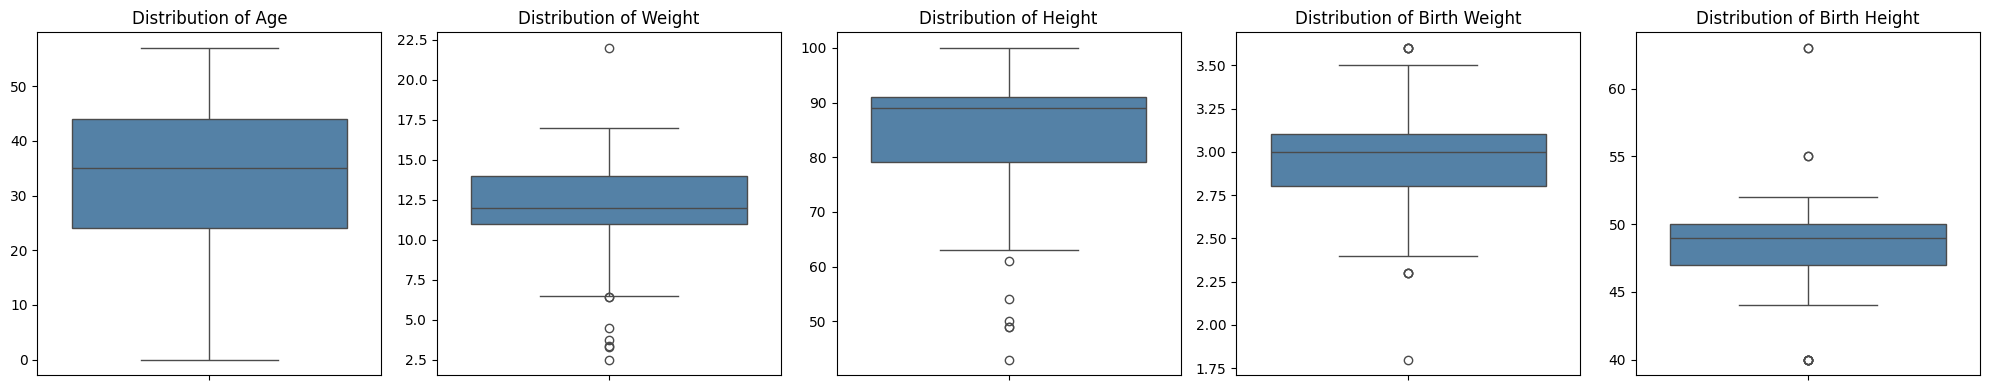

In [ ]:
def create_boxplots(df):
    # Get numerical columns for plotting, excluding 'status_encoded'
    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in ['status_encoded']]

    if len(numeric_cols) == 0:
        print("No numerical columns found in the dataset")
        return

    # Create subplots for multiple boxplots
    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(4*len(numeric_cols), 4))

    # Handle case where there's only one numeric column
    if len(numeric_cols) == 1:
        axes = [axes]

    # Create boxplot for each numerical column
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color='steelblue')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('')  # Remove Y-axis label

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Usage
try:
    # Load the data
    df, le = load_data("stunting.csv")

    # Explore the data
    explore_data(df)

    # Create visualizations
    create_boxplots(df)

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise  # This will show the full error traceback

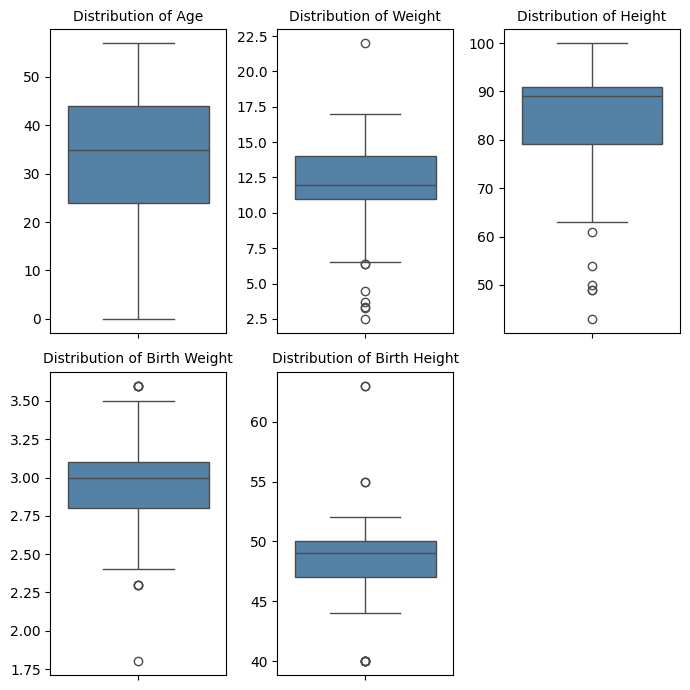

In [ ]:
def create_boxplots(df, figsize=(7, 7), title_fontsize=10):
    # Get numerical columns for plotting
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Exclude 'status_encoded' column if it exists
    numeric_cols = numeric_cols.drop('status_encoded', errors='ignore')

    if len(numeric_cols) == 0:
        print("No numerical columns found in the dataset")
        return

    # Create subplots: 2 rows and 3 columns
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Create boxplots for each numerical column
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color='steelblue')
        axes[i].set_title(f'Distribution of {col}', fontsize=title_fontsize)
        axes[i].set_ylabel('')  # Remove Y-axis label

    # Remove unused subplots (if any)
    for j in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Set figsize to (7, 7) or (8, 7) as desired
create_boxplots(df, figsize=(7, 7))  # For a 7x7 figure size

In [ ]:
def detect_outliers(df, column):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

    return outliers, lower_bound, upper_bound

In [ ]:
# Load the dataset
df, le = load_data("stunting.csv")

In [ ]:
# Function to replace outliers with the median
def replace_outliers_with_median(df, column):
    # Detect outliers using the IQR method
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate the median value of the column
    median_value = df[column].median()

    # Replace outliers with the median
    df[column] = df[column].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    return df

# Load the dataset
df, le = load_data("stunting.csv")

# Replace outliers for specific columns
columns_to_check = ['Age', 'Weight', 'Height', 'Birth Weight', 'Birth Height']
for col in columns_to_check:
    df = replace_outliers_with_median(df, col)

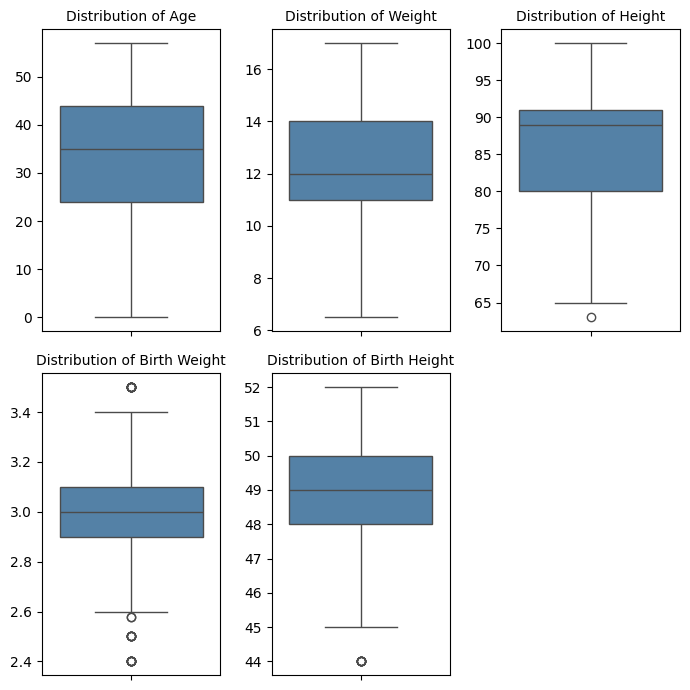

In [ ]:
def create_boxplots(df, figsize=(7, 7), title_fontsize=10):
    # Get numerical columns for plotting
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Exclude 'status_encoded' column if it exists
    numeric_cols = numeric_cols.drop('status_encoded', errors='ignore')

    if len(numeric_cols) == 0:
        print("No numerical columns found in the dataset")
        return

    # Create subplots: 2 rows and 3 columns
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Create boxplots for each numerical column
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color='steelblue')
        axes[i].set_title(f'Distribution of {col}', fontsize=title_fontsize)  # Set fontsize for the title
        axes[i].set_ylabel('')  # Remove Y-axis label

    # Remove unused subplots (if any)
    for j in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Set figsize to (7, 7) or (8, 7) as desired
create_boxplots(df, figsize=(7, 7))  # For a 7x7 figure size

In [ ]:
# Function to handle outliers using Winsorization
def winsorize_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                   # Interquartile range

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Winsorize the outliers
    df[column] = df[column].apply(lambda x: max(lower_bound, min(x, upper_bound)))
    return df

In [ ]:
# Load the dataset
df, le = load_data("stunting.csv")

# Apply winsorization to handle outliers for specific columns
columns_to_check = ['Age', 'Weight', 'Height', 'Birth Weight', 'Birth Height']
for col in columns_to_check:
    df = winsorize_outliers(df, col)

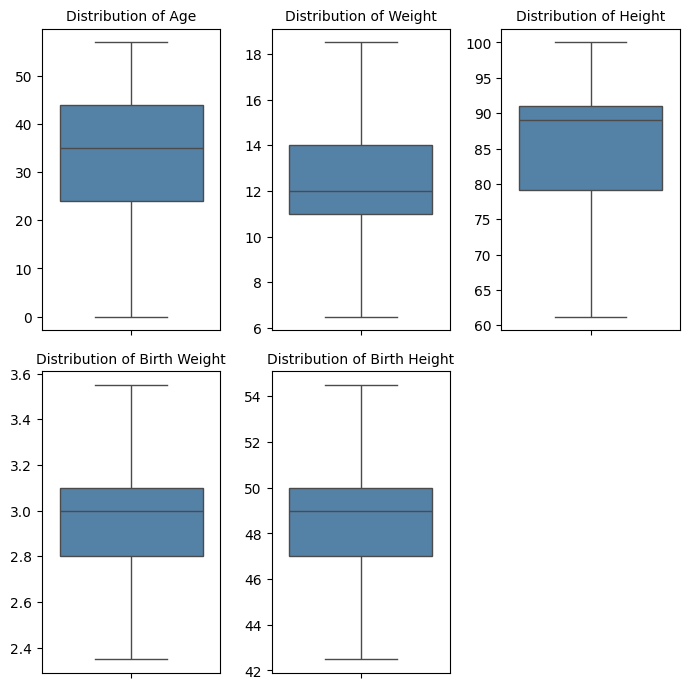

In [ ]:
def create_boxplots(df, figsize=(7, 7), title_fontsize=10):
    # Get numerical columns for plotting
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Exclude 'status_encoded' column if it exists
    numeric_cols = numeric_cols.drop('status_encoded', errors='ignore')

    if len(numeric_cols) == 0:
        print("No numerical columns found in the dataset")
        return

    # Create subplots: 2 rows and 3 columns
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Create boxplots for each numerical column
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color='steelblue')
        axes[i].set_title(f'Distribution of {col}', fontsize=title_fontsize)
        axes[i].set_ylabel('')  # Remove Y-axis label

    # Remove unused subplots (if any)
    for j in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Set figsize to (7, 7) or (8, 7) as desired
create_boxplots(df, figsize=(7, 7))  # For a 7x7 figure size

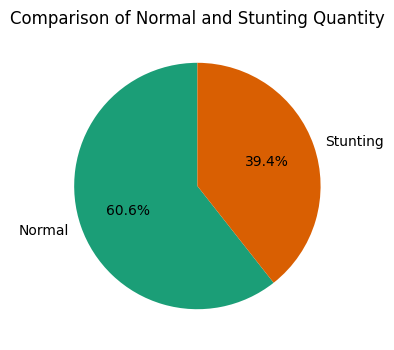

In [ ]:
# Menghitung jumlah data berdasarkan status
status_counts = df.groupby('status').size()

# Membuat pie chart
status_counts.plot(
    kind='pie',
    autopct='%1.1f%%',  # Menampilkan persentase
    colors=sns.color_palette('Dark2'),  # Menggunakan palet warna dari seaborn
    startangle=90,  # Memutar pie chart agar dimulai dari sudut 90 derajat
    figsize=(4, 4)  # Menentukan ukuran figure
)

# Menambahkan judul
plt.title('Comparison of Normal and Stunting Quantity')

# Menampilkan plot
plt.ylabel('')  # Menghapus label default pada pie chart
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_data(filepath):
    # Read CSV file with ; as the delimiter
    df = pd.read_csv(filepath, delimiter=";", encoding="latin1")

    # Encoding 'Gender' feature
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].str.strip().str.upper()
        df['gender_encoded'] = df['Gender'].map({'L': 0, 'P': 1})

    # Create binary status column for stunting if 'TB/U' column exists
    le = None
    if 'TB/U' in df.columns:
        df['status'] = df['TB/U'].apply(lambda x: 'Stunting' if x in ['Sangat Pendek', 'Pendek'] else 'Normal')
        le = LabelEncoder()
        df['status_encoded'] = le.fit_transform(df['status'])

    return df, le

In [ ]:
df, le = load_data('stunting.csv')
print(df.head())

   Age  Weight  Height           TB/U Gender  Birth Weight  Birth Height  \
0   33    11.0    84.0         Pendek      L          3.00          48.0   
1   37    10.0    87.0         Pendek      L          3.10          50.0   
2   10     6.4    67.0         Pendek      P          3.00          48.0   
3    1     3.3    49.0  Sangat Pendek      P          2.95          47.0   
4   50    13.7    89.0  Sangat Pendek      P          3.00          49.0   

   gender_encoded    status  status_encoded  
0               0  Stunting               1  
1               0  Stunting               1  
2               1  Stunting               1  
3               1  Stunting               1  
4               1  Stunting               1  


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
def prepare_data_kfold(df, n_splits=5):
    # Select features
    X = df[['Age', 'Weight', 'Height', 'gender_encoded', 'Birth Weight', 'Birth Height']]

    # Use binary status as target
    y = df['status_encoded']

    # Create KFold cross-validation object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    return X, y, kf

In [ ]:
from sklearn.model_selection import cross_validate

def perform_cross_validation(model, X, y, kf):
    # Create a pipeline that includes scaling and SMOTE
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Perform cross-validation with multiple scoring metrics
    cv_results = cross_validate(
        pipeline,
        X, y,
        cv=kf,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=True
    )

    # Print detailed results
    print("Cross-validation results:")
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
        print(f"{metric.replace('test_', '').capitalize()}:")
        print(f"  Scores: {cv_results[metric]}")
        print(f"  Mean: {cv_results[metric].mean():.4f}")
        print(f"  Std: {cv_results[metric].std():.4f}\n")

    return cv_results

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Persiapan data
X, y, kf = prepare_data_kfold(df)

# Contoh dengan Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_results = perform_cross_validation(rf_model, X, y, kf)

# Contoh dengan Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_results = perform_cross_validation(lr_model, X, y, kf)

Cross-validation results:
Accuracy:
  Scores: [0.92307692 0.87179487 0.87179487 0.78947368 0.94736842]
  Mean: 0.8807
  Std: 0.0543

Precision:
  Scores: [0.92857143 0.82352941 1.         0.73333333 1.        ]
  Mean: 0.8971
  Std: 0.1043

Recall:
  Scores: [0.86666667 0.875      0.6875     0.73333333 0.85714286]
  Mean: 0.8039
  Std: 0.0779

F1:
  Scores: [0.89655172 0.84848485 0.81481481 0.73333333 0.92307692]
  Mean: 0.8433
  Std: 0.0665

Cross-validation results:
Accuracy:
  Scores: [0.8974359  0.87179487 0.82051282 0.81578947 0.86842105]
  Mean: 0.8548
  Std: 0.0316

Precision:
  Scores: [0.92307692 0.76190476 0.84615385 0.78571429 0.76470588]
  Mean: 0.8163
  Std: 0.0614

Recall:
  Scores: [0.8        1.         0.6875     0.73333333 0.92857143]
  Mean: 0.8299
  Std: 0.1176

F1:
  Scores: [0.85714286 0.86486486 0.75862069 0.75862069 0.83870968]
  Mean: 0.8156
  Std: 0.0473



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

def evaluate_model_kfold(X, y, model, label_encoder, kf):
    # Store metrics for each fold
    fold_metrics = {
        'accuracies': [],
        'precisions_normal': [],
        'precisions_stunting': [],
        'recalls_normal': [],
        'recalls_stunting': [],
        'f1_normal': [],
        'f1_stunting': []
    }

    # Store predictions and ground truth from all folds
    all_y_true = []
    all_y_pred = []

    # Store data distributions
    all_distributions = {
        'before_sampling': [],
        'after_sampling': []
    }

    # Iterate through folds
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        print(f"\n{'='*50}")
        print(f"FOLD {fold}")
        print('='*50)

        # Split train and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        print("\nData Distribution:")
        print(f"Train set shape: {X_train.shape}")
        print(f"Test set shape: {X_test.shape}")

        # Show class distribution before oversampling
        train_dist_before = pd.Series(y_train).value_counts()
        test_dist = pd.Series(y_test).value_counts()

        print("\nClass Distribution Before Oversampling:")
        print("Train Data:")
        for idx, count in train_dist_before.items():
            class_name = label_encoder.classes_[idx]
            print(f"{class_name}: {count}")
        print("\nTest Data:")
        for idx, count in test_dist.items():
            class_name = label_encoder.classes_[idx]
            print(f"{class_name}: {count}")

        # Create and fit scaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Apply SMOTE to training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

        # Show class distribution after oversampling
        train_dist_after = pd.Series(y_train_resampled).value_counts()
        print("\nClass Distribution After Oversampling:")
        print("Train Data:")
        for idx, count in train_dist_after.items():
            class_name = label_encoder.classes_[idx]
            print(f"{class_name}: {count}")

        # Store distributions for summary
        all_distributions['before_sampling'].append(train_dist_before)
        all_distributions['after_sampling'].append(train_dist_after)

        # Fit model and predict
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics for this fold
        report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

        # Show results per fold
        print(f"\nFold {fold} Results:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        # Store scores
        fold_metrics['accuracies'].append(report['accuracy'] * 100)
        fold_metrics['precisions_normal'].append(report['Normal']['precision'] * 100)
        fold_metrics['precisions_stunting'].append(report['Stunting']['precision'] * 100)
        fold_metrics['recalls_normal'].append(report['Normal']['recall'] * 100)
        fold_metrics['recalls_stunting'].append(report['Stunting']['recall'] * 100)
        fold_metrics['f1_normal'].append(report['Normal']['f1-score'] * 100)
        fold_metrics['f1_stunting'].append(report['Stunting']['f1-score'] * 100)

        # Store predictions for aggregate analysis
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    # Calculate average macro metrics across folds
    macro_precision = (np.mean(fold_metrics['precisions_normal']) + np.mean(fold_metrics['precisions_stunting'])) / 2
    macro_recall = (np.mean(fold_metrics['recalls_normal']) + np.mean(fold_metrics['recalls_stunting'])) / 2
    macro_f1 = (np.mean(fold_metrics['f1_normal']) + np.mean(fold_metrics['f1_stunting'])) / 2
    avg_precision_stunting = np.mean(fold_metrics['precisions_stunting'])
    avg_precision_normal = np.mean(fold_metrics['precisions_normal'])
    avg_recall_stunting = np.mean(fold_metrics['recalls_stunting'])
    avg_recall_normal = np.mean(fold_metrics['recalls_normal'])
    avg_f1_stunting = np.mean(fold_metrics['f1_stunting'])
    avg_f1_normal = np.mean(fold_metrics['f1_normal'])

    # Print cross-validation summary in desired format
    print("\nCross-Validation Results:")
    print(f"Accuracy            : {np.mean(fold_metrics['accuracies']):.2f}%")
    print(f"Precision (Macro Avg): {macro_precision:.2f}%")
    print(f"Precision (Stunting): {avg_precision_stunting:.2f}%")
    print(f"Precision (Normal)  : {avg_precision_normal:.2f}%")
    print(f"Recall (Macro Avg)   : {macro_recall:.2f}%")
    print(f"Recall (Stunting)   : {avg_recall_stunting:.2f}%")
    print(f"Recall (Normal)     : {avg_recall_normal:.2f}%")
    print(f"F1-Score (Macro Avg) : {macro_f1:.2f}%")
    print(f"F1-Score (Stunting) : {avg_f1_stunting:.2f}%")
    print(f"F1-Score (Normal)   : {avg_f1_normal:.2f}%")

    # Create confusion matrix from aggregated predictions
    final_conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    # Plot the global confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Global Confusion Matrix (All Folds)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Show aggregate classification report
    print("\nGlobal Classification Report (All Folds):")
    print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

    return fold_metrics


--- Random Forest Evaluation ---

FOLD 1

Data Distribution:
Train set shape: (154, 6)
Test set shape: (39, 6)

Class Distribution Before Oversampling:
Train Data:
Normal: 93
Stunting: 61

Test Data:
Normal: 24
Stunting: 15

Class Distribution After Oversampling:
Train Data:
Stunting: 93
Normal: 93

Fold 1 Results:
              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94        24
    Stunting       0.93      0.87      0.90        15

    accuracy                           0.92        39
   macro avg       0.92      0.91      0.92        39
weighted avg       0.92      0.92      0.92        39


FOLD 2

Data Distribution:
Train set shape: (154, 6)
Test set shape: (39, 6)

Class Distribution Before Oversampling:
Train Data:
Normal: 94
Stunting: 60

Test Data:
Normal: 23
Stunting: 16

Class Distribution After Oversampling:
Train Data:
Stunting: 94
Normal: 94

Fold 2 Results:
              precision    recall  f1-score   support

      Normal    

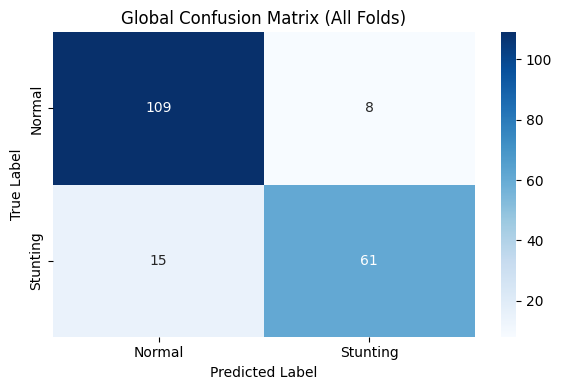


Global Classification Report (All Folds):
              precision    recall  f1-score   support

      Normal       0.88      0.93      0.90       117
    Stunting       0.88      0.80      0.84        76

    accuracy                           0.88       193
   macro avg       0.88      0.87      0.87       193
weighted avg       0.88      0.88      0.88       193


--- Logistic Regression Evaluation ---

FOLD 1

Data Distribution:
Train set shape: (154, 6)
Test set shape: (39, 6)

Class Distribution Before Oversampling:
Train Data:
Normal: 93
Stunting: 61

Test Data:
Normal: 24
Stunting: 15

Class Distribution After Oversampling:
Train Data:
Stunting: 93
Normal: 93

Fold 1 Results:
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92        24
    Stunting       0.92      0.80      0.86        15

    accuracy                           0.90        39
   macro avg       0.90      0.88      0.89        39
weighted avg       0.90      0.90 

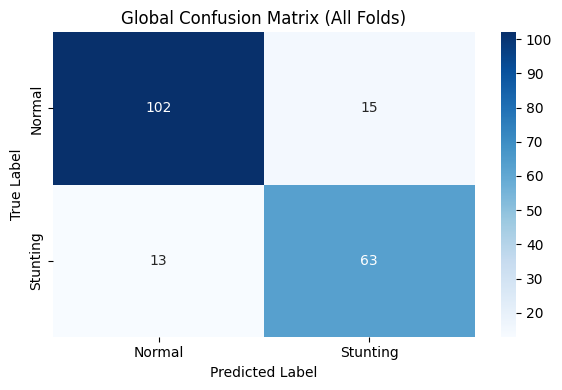


Global Classification Report (All Folds):
              precision    recall  f1-score   support

      Normal       0.89      0.87      0.88       117
    Stunting       0.81      0.83      0.82        76

    accuracy                           0.85       193
   macro avg       0.85      0.85      0.85       193
weighted avg       0.86      0.85      0.86       193



In [ ]:
def main():
    # Load data with label encoder
    df, le = load_data('stunting.csv')

    # Prepare data for K-Fold
    X, y, kf = prepare_data_kfold(df, n_splits=5)

    # Evaluate Random Forest
    print("\n--- Random Forest Evaluation ---")
    rf_model = RandomForestClassifier(random_state=42)
    rf_results = evaluate_model_kfold(X, y, rf_model, le, kf)

    # Evaluate Logistic Regression
    print("\n--- Logistic Regression Evaluation ---")
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_results = evaluate_model_kfold(X, y, lr_model, le, kf)

if __name__ == "__main__":
    main()